In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import tensorflow as tf
import scipy
import time

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def re_order_images(img):
    classes = [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11]
    new_img = np.zeros((img.shape[0], img.shape[1], len(classes)))
    for i, x in enumerate(classes):
        x, y = np.where(img[:, :, 0] == x/255)
        new_img[x, y, i] = img[x, y, 0]
    return new_img

In [3]:
def preprocess_labels(label_image):
    labels_new = np.copy(label_image)
    # Identify lane marking pixels (label is 6)
    # Set lane marking pixels to road (label is 7)
    labels_new[np.where(label_image[:, :, 0] == 6/255)] = 7/255
    
    # Identify all vehicle pixels
    vehicle_pixels = (label_image[:,:,0] == 10/255).nonzero()
    # Isolate vehicle pixels associated with the hood (y-position > 496)
    hood_indices = (vehicle_pixels[0] >= 496).nonzero()[0]
    hood_pixels = (vehicle_pixels[0][hood_indices], \
                   vehicle_pixels[1][hood_indices])
    # Set hood pixel labels to 0
    labels_new[hood_pixels] = 0
    new_img = re_order_images(labels_new)
    return new_img


In [4]:
cwd = os.path.curdir
dir_name = os.path.join(cwd, '../data/Train/CameraSeg/')
label_arr = []
for filename in os.listdir(dir_name):
    filename = os.path.join(dir_name, filename)
    label = plt.imread(filename)
    label_arr.append(preprocess_labels(label))


In [5]:
labels = np.stack(label_arr)
print(labels.shape)

MemoryError: 

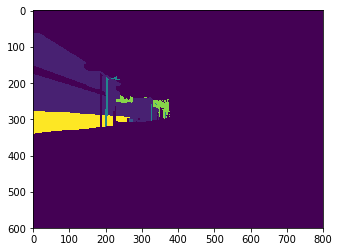

In [60]:
import random
plt.imshow(random.choice(labels)[:, :, 1])

In [61]:
image_dir_name = os.path.join(cwd, 'Train/CameraRGB/')
image_arr = []
for filename in os.listdir(image_dir_name):
    filename = os.path.join(image_dir_name, filename)
    image = plt.imread(filename)
    image_arr.append(image)
images = np.array(image_arr)

In [62]:
print(labels.shape, images.shape)

(1000, 600, 800, 11) (1000, 600, 800, 3)


In [63]:
def split_train_data(size):
    for i in range(0, images.shape[0], size):
        batch_images = images[i:i+size]
        batch_labels = labels[i:i+size]
        batch_images, batch_labels
    

In [73]:
def load_vgg_pretrained(sess, vgg_path):
    vgg_tag = 'vgg16'
    vgg_input_tensor_name = 'image_input:0'
    vgg_keep_prob_tensor_name = 'keep_prob:0'
    vgg_layer3_out_tensor_name = 'layer3_out:0'
    vgg_layer4_out_tensor_name = 'layer4_out:0'
    vgg_layer7_out_tensor_name = 'layer7_out:0'
    graph = tf.get_default_graph()
    tf.saved_model.loader.load(sess, [vgg_tag], vgg_path)
    w1 = graph.get_tensor_by_name(vgg_input_tensor_name)
    keep_prob = graph.get_tensor_by_name(vgg_keep_prob_tensor_name)
    layer3 = graph.get_tensor_by_name(vgg_layer3_out_tensor_name)
    layer4 = graph.get_tensor_by_name(vgg_layer4_out_tensor_name)
    layer7 = graph.get_tensor_by_name(vgg_layer7_out_tensor_name)
    return w1, keep_prob, layer3, layer4, layer7

with tf.Session() as sess:
    load_vgg_pretrained(sess, 'vgg/')
    

INFO:tensorflow:Restoring parameters from b'vgg/variables/variables'


In [74]:
def layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes):
    """
    Create the layers for a fully convolutional network.  Build skip-layers using the vgg layers.
    :param vgg_layer7_out: TF Tensor for VGG Layer 3 output
    :param vgg_layer4_out: TF Tensor for VGG Layer 4 output
    :param vgg_layer3_out: TF Tensor for VGG Layer 7 output
    :param num_classes: Number of classes to classify
    :return: The Tensor for the last layer of output
    """
    # Layer 7 upsampling
    layer7_out = tf.layers.conv2d(vgg_layer7_out, num_classes, 1, 
                                   padding= 'same', 
                                   kernel_initializer= tf.random_normal_initializer(stddev=0.01),
                                   kernel_regularizer= tf.contrib.layers.l2_regularizer(1e-3))
    # upsample
    layer4_in = tf.layers.conv2d_transpose(layer7_out, num_classes, 4, 
                                             strides= (2, 2), 
                                             padding= 'same', 
                                             kernel_initializer= tf.random_normal_initializer(stddev=0.01), 
                                             kernel_regularizer= tf.contrib.layers.l2_regularizer(1e-3))
   
    layer4_in2 = tf.layers.conv2d(vgg_layer4_out, num_classes, 1, 
                                   padding= 'same', 
                                   kernel_initializer= tf.random_normal_initializer(stddev=0.01), 
                                   kernel_regularizer= tf.contrib.layers.l2_regularizer(1e-3))
    # skip connection (element-wise addition)
    layer4_out = tf.add(layer4_in, layer4_in2)
    layer3_in = tf.layers.conv2d_transpose(layer4_out, num_classes, 4, 
                                             strides= (2, 2), 
                                             padding= 'same', 
                                             kernel_initializer= tf.random_normal_initializer(stddev=0.01), 
                                             kernel_regularizer= tf.contrib.layers.l2_regularizer(1e-3))
    
    layer3_in2 = tf.layers.conv2d(vgg_layer3_out, num_classes, 1, 
                                   padding= 'same', 
                                   kernel_initializer= tf.random_normal_initializer(stddev=0.01), 
                                   kernel_regularizer= tf.contrib.layers.l2_regularizer(1e-3))
    layer3_out = tf.add(layer3_in, layer3_in2)
    
    last_layer = tf.layers.conv2d_transpose(layer3_out, num_classes, 16,  
                                               strides= (8, 8), 
                                               padding= 'same', 
                                               kernel_initializer= tf.random_normal_initializer(stddev=0.01), 
                                               kernel_regularizer= tf.contrib.layers.l2_regularizer(1e-3))
    return last_layer

In [66]:
def optimize(nn_last_layer, correct_label, learning_rate, num_classes):
    """
    Build the TensorFLow loss and optimizer operations.
    :param nn_last_layer: TF Tensor of the last layer in the neural network
    :param correct_label: TF Placeholder for the correct label image
    :param learning_rate: TF Placeholder for the learning rate
    :param num_classes: Number of classes to classify
    :return: Tuple of (logits, train_op, cross_entropy_loss)
    """
    # TODO: Implement function
    logits = tf.reshape(nn_last_layer, (-1, num_classes))
    labels = tf.reshape(correct_label, (-1, num_classes))
    print(nn_last_layer.shape, labels.shape)
    cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits= logits, 
                                                                                labels= labels))
    optimizer = tf.train.AdamOptimizer(learning_rate= learning_rate)
    train_op = optimizer.minimize(cross_entropy_loss)
    return logits, train_op, cross_entropy_loss

In [76]:
def train_nn(sess, epochs, batch_size, train_op, cross_entropy_loss, input_image,
             correct_label, keep_prob, learning_rate):
    """
    Train neural network and print out the loss during training.
    :param sess: TF Session
    :param epochs: Number of epochs
    :param batch_size: Batch size
    :param get_batches_fn: Function to get batches of training data.  Call using get_batches_fn(batch_size)
    :param train_op: TF Operation to train the neural network
    :param cross_entropy_loss: TF Tensor for the amount of loss
    :param input_image: TF Placeholder for input images
    :param correct_label: TF Placeholder for label images
    :param keep_prob: TF Placeholder for dropout keep probability
    :param learning_rate: TF Placeholder for learning rate
    """
    # TODO: Implement function
    for epoch in range(epochs):
        s_time = time.time()
        for i in range(0, images.shape[0], batch_size):
            image = images[i:i+batch_size]
            targets = labels[i:i+batch_size]
            _, loss = sess.run([train_op, cross_entropy_loss], 
                feed_dict = {input_image: image, correct_label: targets, keep_prob: 0.5 ,
                             learning_rate: 1e-4 })
        print("Epoch: {}".format(epoch + 1), "/ {}".format(epochs), " Loss: {:.3f}".format(loss), " Time: ",
              str(timedelta(seconds=(time.time() - s_time))))

In [77]:
def save_inference_samples(runs_dir, data_dir, sess, image_shape, logits, keep_prob, input_image):
    # Make folder for current run
    output_dir = os.path.join(runs_dir, str(time.time()))
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)

    # Run NN on test images and save them to HD
    print('Training Finished. Saving test images to: {}'.format(output_dir))
    image_outputs = gen_test_output(
        sess, logits, keep_prob, input_image, os.path.join(data_dir, 'data_road/testing'), image_shape)
    for name, image in image_outputs:
        scipy.misc.imsave(os.path.join(output_dir, name), image)

In [78]:
def run():
    num_classes = 11
    image_shape = (600, 800)
    data_dir = './data'
    runs_dir = './runs'
    #tests.test_for_kitti_dataset(data_dir)
    learning_rate = 1e-3

    # Download pretrained vgg model
    #helper.maybe_download_pretrained_vgg(data_dir)
    with tf.Session() as sess:
        vgg_path = os.path.join(cwd, 'vgg')
        epochs = 100
        batch_size = 5
        correct_label = tf.placeholder(tf.int32, [None, None, None, num_classes], name='correct_label')
        learning_rate = tf.placeholder(tf.float32, name='learning_rate')
        input_image, keep_prob, vgg_layer3_out, vgg_layer4_out, vgg_layer7_out = load_vgg_pretrained(sess, vgg_path)
        #print(input_image)
        nn_last_layer = layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes)
        logits, train_op, cross_entropy_loss = optimize(nn_last_layer, correct_label, 
                                                        learning_rate, num_classes)
        sess.run(tf.global_variables_initializer())
        train_nn(sess, epochs, batch_size, train_op, cross_entropy_loss, input_image,
             correct_label, keep_prob, learning_rate)

        # TODO: Save inference data using helper.save_inference_samples
        helper.save_inference_samples(runs_dir, data_dir, sess, image_shape, logits, keep_prob, input_image)

In [ ]:
run()

INFO:tensorflow:Restoring parameters from b'./vgg/variables/variables'
(?, ?, ?, 11) (?, 11)
